In [191]:
%matplotlib inline

In [192]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import tools                           # A few helpers to plot multiple images
from PIL import Image                  # For rescaling images
from ipywidgets import interact, fixed # Interact with images

In [202]:
img_link = 'images/sudoku/sudoku_00201.png'

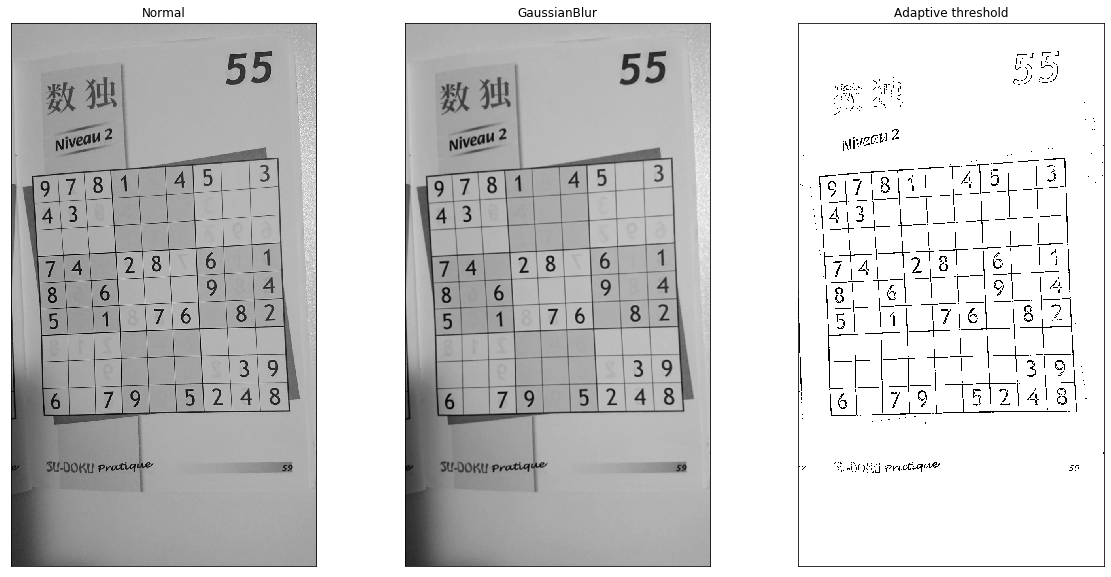

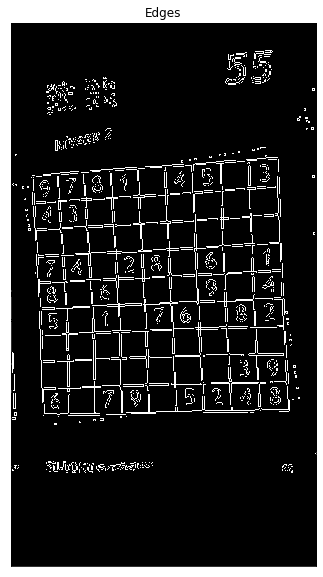

In [203]:
# prefiltrering and scaling 

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

iGausKernelSize = 5
imgFilt = cv2.GaussianBlur(img, (iGausKernelSize, iGausKernelSize), 0)

imgThresh = cv2.adaptiveThreshold(imgFilt, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY, 3, 5)

iReducFactor = 2
iStart = iReducFactor // 2
imgReduc = imgThresh[iStart::iReducFactor, iStart::iReducFactor]
   
# compute the median of the single channel pixel intensities
med = np.median(imgReduc)
 
# apply automatic Canny edge detection using the computed median
sigma = 0.3
loThreshold = int( max( 0, (1.0 - sigma) * med))
hiThreshold = int( min( 255, (1.0 + sigma) * med))

edges = cv2.Canny(imgReduc, loThreshold, hiThreshold, apertureSize=3, L2gradient=False)

#cv2.imwrite('sudoku.png', edges)

# plot all the images
tools.multiPlot( 1, 3, (img, imgFilt, imgThresh,),
                       ('Normal', 'GaussianBlur', 'Adaptive threshold',),
                        cmap_tuple=(cm.gray, cm.gray, cm.gray,))

tools.multiPlot(1, 1, (edges,), ('Edges',), cmap_tuple=(cm.gray,))

In [204]:
#Hough 

#def update(minLineLength=30, maxLineGap=20):
#    img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
#    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,np.array([]),minLineLength,maxLineGap)
#    for l in lines:
#        for x1,y1,x2,y2 in l:
#            cv2.line(img,(2*x1,2*y1),(2*x2,2*y2),(0,255,0),3)



#    tools.multiPlot(1, 2, (img, edges),
#                        ('Original image', 'Canny'),
#                        cmap_tuple=(cm.gray, cm.gray))
#interact(update, minLineLength = (10, 60, 5), maxLineGap = (15, 30, 1))

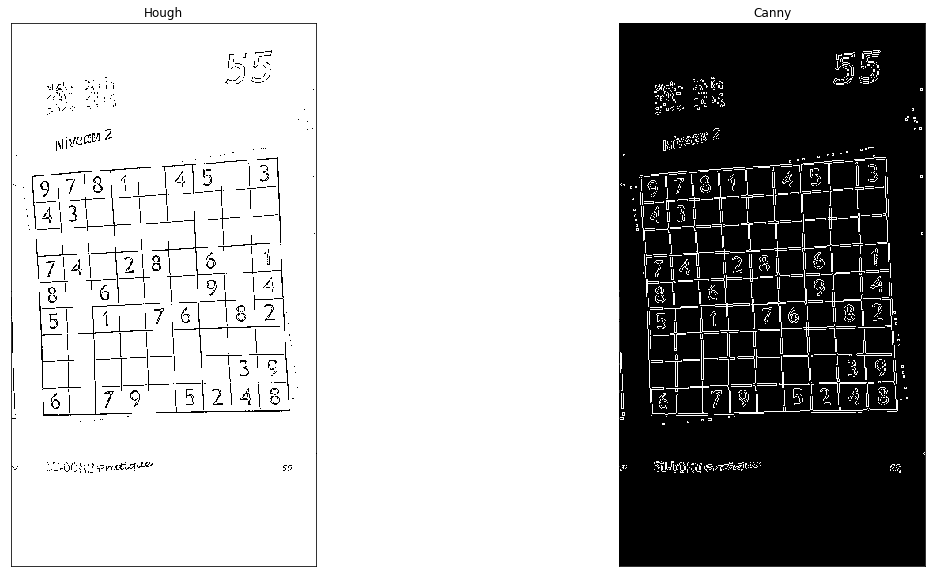

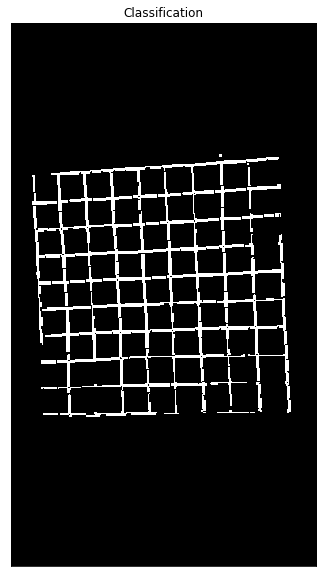

In [205]:
height, width = img.shape[:2]
mat = np.zeros((height,width))

minLineLength = 30
maxLineGap = 20

lines = cv2.HoughLinesP(edges,1,np.pi/180,100,np.array([]),minLineLength,maxLineGap)
for l in lines:
    for x1,y1,x2,y2 in l:
        cv2.line(mat,(2*x1,2*y1),(2*x2,2*y2),(255, 255, 255),3)
        cv2.line(img_color,(2*x1,2*y1),(2*x2,2*y2),(255,0,0),3)

iReducFactor = 2
iStart = iReducFactor // 2
blackReduc = mat[iStart::iReducFactor, iStart::iReducFactor]


tools.multiPlot(1, 2, (imgReduc, edges),
                        ('Hough', 'Canny'),
                        cmap_tuple=(cm.gray, cm.gray))


blackReduc = blackReduc.astype('uint8')

img_and = cv2.bitwise_and(blackReduc, edges)

dilated = cv2.dilate(img_and, np.ones((2,2), dtype=np.uint8))

tools.multiPlot(1, 1, (dilated,), ('Classification',), cmap_tuple=(cm.gray,))

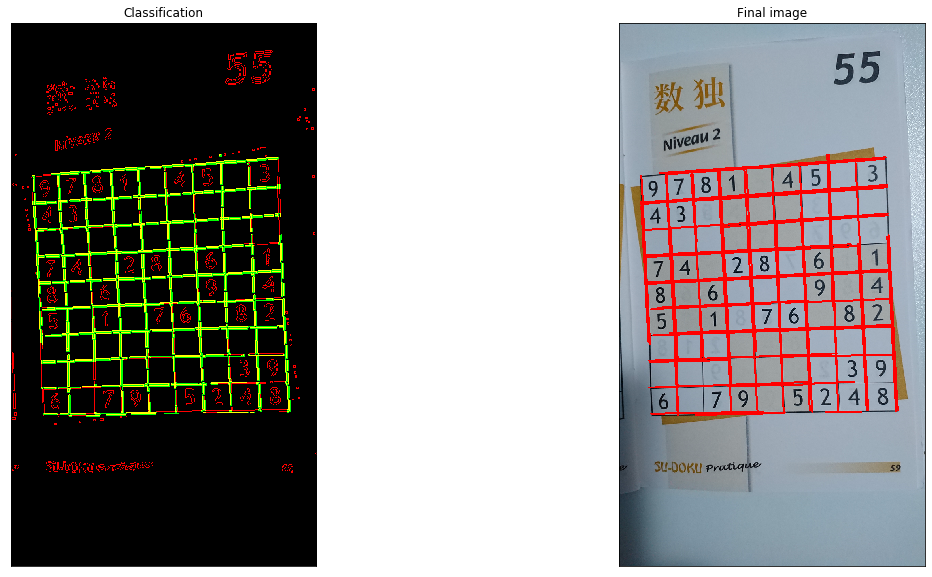

In [206]:
colored = np.zeros((dilated.shape[0], dilated.shape[1], 3), dtype='uint8')

colored[:,:,0] = edges
colored[:,:,1] = dilated

tools.multiPlot(1, 2, (colored, img_color), ('Classification', 'Final image',), cmap_tuple=(cm.gray, cm.gray,))